In [1]:
import mysql.connector
# library for data analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense
from sklearn.model_selection import train_test_split 
from sklearn.metrics.pairwise import cosine_similarity

import os 

In [3]:
# Membuat koneksi ke database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='',
    database='tourista_db'
)

In [4]:
# Mengeksekusi query untuk mengambil data dari tabel

query = "SELECT * FROM destination"
destination = pd.read_sql_query(query, conn)

query = "SELECT * FROM review_wisata"
ratings = pd.read_sql_query(query, conn)

query = "SELECT * FROM user_profile"
users = pd.read_sql_query(query, conn)

C:\Users\dewan\AppData\Local\Temp\ipykernel_4100\707316895.py:4: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  destination = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_4100\707316895.py:7: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  ratings = pd.read_sql_query(query, conn)
C:\Users\dewan\AppData\Local\Temp\ipykernel_4100\707316895.py:10: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  users = pd.read_sql_query(query, conn)


In [ ]:
ratings.head(2)

,user_wisata,wisata_id,wisata_rating
0,1,179,3.0
1,1,344,2.0


In [5]:
train, test = train_test_split(ratings, test_size = 0.2)

In [6]:
number_user = len(ratings['user_wisata'].unique())
number_destination = len(ratings['wisata_id'].unique())

print(f'number of user = {number_user}')
print(f'number of place name = {number_destination}')

number of user = 300
number of place name = 437


In [36]:
# build recommendation system using emmbedding layers dan dropout(to overcome the overfitting)

from tensorflow.keras.models import Model 
from tensorflow.keras.layers import Input, Embedding, Dot, Flatten, Dense, Dropout 

EMBEDDING_DIM = 50

# input layers 
place_input = Input(shape=[1])
user_input = Input(shape=[1])

# embedding layers add dropout 
place_embedding = Embedding(number_destination+1 , EMBEDDING_DIM)(place_input)
place_embedding = Dropout(0.2)(place_embedding)

user_embedding = Embedding(number_user+1 , EMBEDDING_DIM)(user_input)
user_embedding = Dropout(0.2)(user_embedding)

# flatten the embedddings
place_flat = Flatten()(place_embedding)
user_flat = Flatten()(user_embedding)

# output layer
output = Dot(1)([place_flat, user_flat])

# the model
model = Model([place_input, user_input], [output])

In [37]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

early_stopping = EarlyStopping(patience=5, restore_best_weights=True)
model.compile(optimizer=Adam(learning_rate = 0.0005), loss='mean_squared_error') 

In [38]:
history = model.fit(x= [train.wisata_id, train.user_wisata], 
                    y= train.wisata_rating, 
                    validation_data = ([train.wisata_id, train.user_wisata], train.wisata_rating), 
                    epochs =18,
                    callbacks=[early_stopping],)

Epoch 1/18
250/250 [==============================] - 2s 4ms/step - loss: 11.2599 - val_loss: 11.2352
Epoch 2/18
250/250 [==============================] - 1s 3ms/step - loss: 11.2300 - val_loss: 11.1949
Epoch 3/18
250/250 [==============================] - 1s 3ms/step - loss: 11.1740 - val_loss: 11.1071
Epoch 4/18
250/250 [==============================] - 1s 3ms/step - loss: 11.0345 - val_loss: 10.8837
Epoch 5/18
250/250 [==============================] - 1s 3ms/step - loss: 10.6919 - val_loss: 10.3753
Epoch 6/18
250/250 [==============================] - 1s 3ms/step - loss: 10.0025 - val_loss: 9.4691
Epoch 7/18
250/250 [==============================] - 1s 3ms/step - loss: 8.9119 - val_loss: 8.1803
Epoch 8/18
250/250 [==============================] - 1s 3ms/step - loss: 7.5122 - val_loss: 6.6842
Epoch 9/18
250/250 [==============================] - 1s 3ms/step - loss: 6.0110 - val_loss: 5.2162
Epoch 10/18
250/250 [==============================] - 1s 3ms/step - loss: 4.6608 - val_l

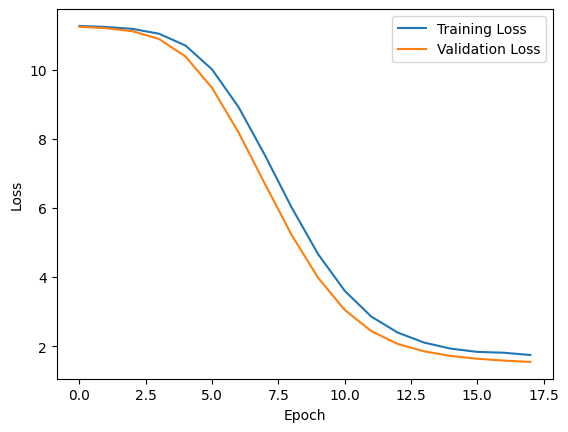

In [39]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

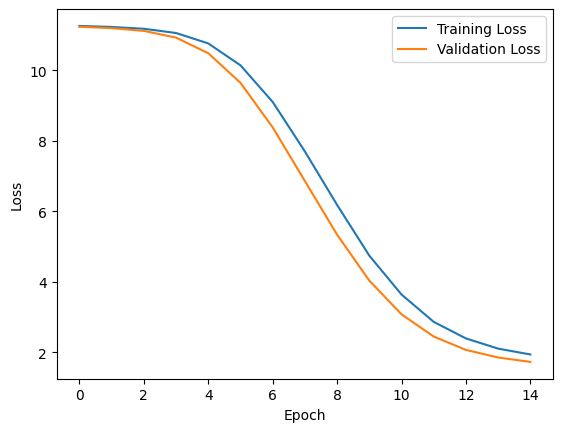

In [35]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
# calculations for "haversine distance" and complementary functions for collaborative filtering
from math import radians

def haversine_distance(lat1, long1, lat2, long2):
    earth_radius = 6371  # Radius of the Earth in kilometers (source: google)
    lat1_rad = np.radians(lat1)
    long1_rad = np.radians(long1)
    lat2_rad = np.radians(lat2)
    long2_rad = np.radians(long2)
    diff_lat = lat2_rad - lat1_rad
    diff_long = long2_rad - long1_rad
    a = np.sin(diff_lat / 2) ** 2 + np.cos(lat1_rad) * np.cos(lat2_rad) * np.sin(diff_long / 2) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    distance = earth_radius * c
    return distance

def filter_by_location(destination, user_lat, user_long, max_distance):
    destination['distance'] = haversine_distance(destination['destination_lat'], destination['destination_long'], user_lat, user_long)
    destination = destination[destination['distance'] <= max_distance]
    destination = destination.drop('distance', axis=1)
    return destination

def filter_by_city(destination):
    city_filter = ['Jakarta', 'Bandung', 'Yogyakarta', 'Semarang', 'Surabaya']
    destination = destination[destination['city'].isin(city_filter)]
    return destination

In [21]:
# recommendation system function using collaborative filtering
def collaborative_rec(User_Id, destination ,model, np_val, u_lat, u_long ):
    # detail user : digunakan untuk menyimpan data detail user untuk mengerucutkan data yang akan di outputkan
    
    if User_Id in ratings['user_wisata'].values:
            destination = destination.copy()
            user_ids = np.array([User_Id] * len(destination))
            results = model([destination.id.values, user_ids]).numpy().reshape(-1)
    
            destination['predicted_rating'] = pd.Series(results)
            destination = destination.sort_values('predicted_rating', ascending = False)
    else:
            destination = destination.copy()
            destination = destination.sort_values('rating', ascending = False)
    
#     if user_location != '':
#         destination = destination[destination['city'] == user_location]
    
    dataFinal = filter_by_location(destination, u_lat, u_long, 30)
    
    return dataFinal[['name_wisata', 'city','coordinate', 'destination_photo','description_wisata']].to_dict(orient='records')

## Model result

In [18]:
user_location = 'Bandung'
user_lat = -6.1253
user_long = 106.8335

In [22]:
final_result = collaborative_rec(34, destination, model, 5, user_lat, user_long)
final_result

[{'name_wisata': 'Kampung Cina',
  'city': 'Jakarta',
  'coordinate': "{'lat': -6.3651357, 'lng': 106.7617984}",
  'destination_photo': 'lala.png',
  'description_wisata': 'KAMPUNG China adalah hunian dan kawasan perdagangan di Cibubur, Jakarta Timur. Wilayah ini berdiri berkat kerja sama antara Pemerintah Kota Jakarta Timur dengan perusahaan asing untuk menyulap area 300 hektare kawasan wisata Cibubur menjadi kota wisata, m'},
 {'name_wisata': 'Monumen Nasional',
  'city': 'Jakarta',
  'coordinate': "{'lat': -6.1753924, 'lng': 106.8271528}",
  'destination_photo': 'lala.png',
  'description_wisata': 'Monumen Nasional atau yang populer disingkat dengan Monas atau Tugu Monas adalah monumen peringatan setinggi 132 meter (433 kaki) yang didirikan untuk mengenang perlawanan dan perjuangan rakyat Indonesia untuk merebut kemerdekaan dari pemerintahan kolonia'},
 {'name_wisata': 'Alive Museum Ancol',
  'city': 'Jakarta',
  'coordinate': "{'lat': -6.117534399999999, 'lng': 106.857313}",
  'des